# Drifter vs OceanParcels for ASOF2025

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import numpy as np
import xarray as xr

In [2]:
# Load ETOPO1
ds_bath = xr.open_dataset("/albedo/work/user/quraus001/bath/ETOPO_2022_v1_60s_N90W180_bed.nc")

# Crop to Fram Strait region
ds_fram_bath = ds_bath.sel(
    lon=slice(-35, 35),    
    lat=slice(70, 85)      
)

ds_parcels = xr.open_zarr("/albedo/home/quraus001/FESOM-FS-subduction/outdata/temperature-test.zarr", consolidated=True)
ds_parcels

<xarray.Dataset> Size: 12kB
Dimensions:     (trajectory: 20, obs: 30)
Coordinates:
  * obs         (obs) int32 120B 0 1 2 3 4 5 6 7 8 ... 22 23 24 25 26 27 28 29
  * trajectory  (trajectory) int64 160B 100 101 102 103 104 ... 116 117 118 119
Data variables:
    lat         (trajectory, obs) float32 2kB ...
    lon         (trajectory, obs) float32 2kB ...
    time        (trajectory, obs) datetime64[ns] 5kB ...
    z           (trajectory, obs) float32 2kB ...
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        JITParticleAdvectionRK4
    parcels_mesh:           spherical
    parcels_version:        3.1.2

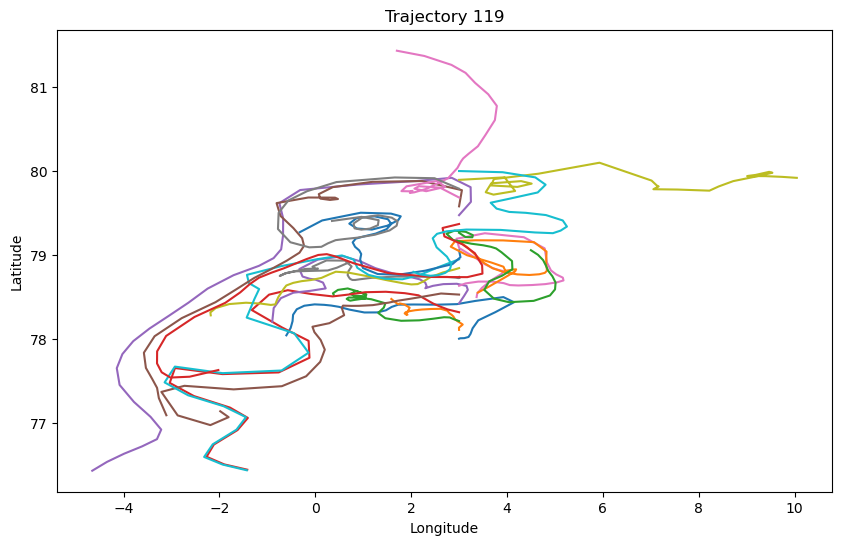

In [5]:
plt.figure(figsize=(10, 6))

for trajectory in ds_parcels.trajectory.values:

    # Calculate the mean temperature for each trajectory    mean_temp = ds_trajectory.temperature.mean(dim="time")
    
    # Create a scatter plot of the trajectory
    plt.plot(ds_parcels.sel(trajectory=trajectory).lon, ds_parcels.sel(trajectory=trajectory).lat)
    plt.title(f'Trajectory {trajectory}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    

In [3]:
inpath_drifter = "/albedo/home/quraus001/FESOM-FS-subduction/data/drifter/MSM93/"
subfolder1 = "202007221235"
subfolder2 = "202012231600"

In [4]:
files_drifter = glob.glob(f"{inpath_drifter}{subfolder2}/*")

In [5]:
# Read the drifter data
DFs = []
for file in files_drifter:
    # Read the data
    df = pd.read_csv(file, sep=",", header=0)
    # Rename the columns Position time (UTC),Reception time (UTC),Latitude (°),Longitude (°),Status, to position_date_time, reception_date_time, latitude, longitude, status
    df.rename(columns={
        'Position time (UTC)': 'position_date_time',
        'Reception time (UTC)': 'reception_date_time',
        'Latitude (°)': 'latitude',
        'Longitude (°)': 'longitude',
        'Status': 'status'
    }, inplace=True)
    # Convert the time column to datetime
    df['reception_date_time'] = pd.to_datetime(df['reception_date_time'], format='%Y-%m-%d %H:%M:%S')
    df['position_date_time'] = pd.to_datetime(df['position_date_time'], format='%Y-%m-%d %H:%M:%S')

    # delete rows where status is 0
    df = df[df['status'] != 0]

    # print rows where latitude and longitude is zero
    #print(df[(df['latitude'] == 0) & (df['longitude'] == 0)])
    # if latitude and longitude is zero delete the row and print the rows
    df = df[(df['latitude'] != 0) & (df['longitude'] != 0)]

    

    # delete rows with latitude smaller than 50
    df = df[df['latitude'] > 50]

    # Append to the list
    DFs.append(df)

In [6]:
def get_colormap_colors(colormap='plasma', num_colors=20):
    # Create a linear space of values from 0 to 1
    values = np.linspace(0, 1, num_colors)
    
    # Get the colormap from matplotlib or try from cmocean
    try:
        cmap = plt.get_cmap(colormap)
    except ValueError:
        # If the colormap is not found, use cmocean
        cmap = getattr(cmo.cm, colormap)

    
    # Get the colors corresponding to the values
    colors = [cmap(val) for val in values]
    
    return colors

KeyboardInterrupt: 

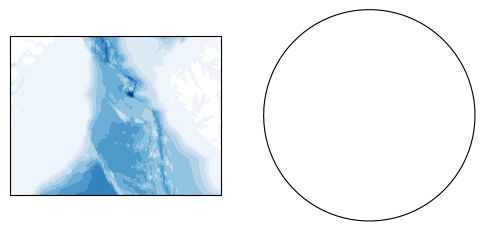

In [10]:
# Plot the data with cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig, axs = plt.subplots(1, 2, subplot_kw={'projection': ccrs.NorthPolarStereo()}, figsize=(6, 8))
ax1, ax2 = axs
for ax in [ax1, ax2]:
    ax.set_extent([-15, 15, 75, 81], crs=ccrs.PlateCarree())

    # Contourf or pcolormesh for bathymetry
    cs = ax.contourf(
        ds_fram_bath['lon'], ds_fram_bath['lat'], ds_fram_bath['z'],
        levels =  np.linspace(-5500, 0, 12) + 0.001,
        cmap="Blues_r",
        extend='min',
        transform=ccrs.PlateCarree(),
        zorder=0
    )

    
    ax.add_feature(cfeature.LAND, color='gray', zorder=1)
    gl = ax.gridlines(draw_labels=False, linewidth=0.5, color='gray', linestyle='--', zorder=200)
    #gl.top_labels = True   # Turn on labels for the top axis
    #gl.bottom_labels = False # Turn off labels for the bottom axis
    #gl.left_labels = True   # Keep labels on the left (optional)
    #gl.right_labels = False  # Turn off labels on the right (optional)

plt.subplots_adjust(wspace=0.05)
# Create the colorbar
cbar = plt.colorbar(cs, ax=axs, orientation='horizontal', label='Depth (m)', shrink=0.6, pad=0.05)
# Invert the colorbar
#cbar.ax.invert_yaxis()

# Plot the drifter data


for i, df in enumerate(DFs[1::2]):
    ax1.plot(df['longitude'], df['latitude'], color=get_colormap_colors(num_colors=len(DFs[1::2]))[i], alpha=1, transform=ccrs.PlateCarree(), linewidth=2)
for i, trajectory in enumerate(ds_parcels.trajectory.values):    
    ax2.plot(ds_parcels.sel(trajectory=trajectory).lon, ds_parcels.sel(trajectory=trajectory).lat, transform=ccrs.PlateCarree(), color=get_colormap_colors(num_colors=len(ds_parcels.trajectory.values))[i], linewidth=2)

ax1.set_title('Drifter Trajectories (MSM93)')
ax2.set_title('OceanParcels FESOM Trajectories')

# save the figure with transparent background
plt.savefig("drifter_trajectories.png", dpi=300, bbox_inches='tight', transparent=True)



plt.show()

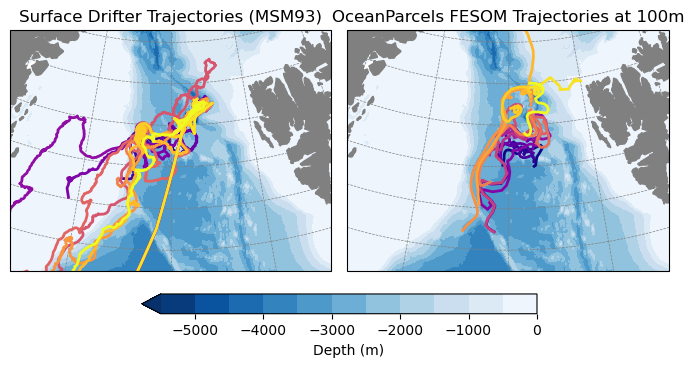

In [7]:
# Plot the data with cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig, axs = plt.subplots(1, 2, subplot_kw={'projection': ccrs.NorthPolarStereo()}, figsize=(8.5, 6))
ax1, ax2 = axs
for ax in [ax1, ax2]:
    ax.set_extent([-15, 15, 75, 81], crs=ccrs.PlateCarree())

    # Contourf or pcolormesh for bathymetry
    cs = ax.contourf(
        ds_fram_bath['lon'], ds_fram_bath['lat'], ds_fram_bath['z'],
        levels =  np.linspace(-5500, 0, 12) + 0.001,
        cmap="Blues_r",
        extend='min',
        transform=ccrs.PlateCarree(),
        zorder=0
    )

    
    ax.add_feature(cfeature.LAND, color='gray', zorder=1)
    gl = ax.gridlines(draw_labels=False, linewidth=0.5, color='gray', linestyle='--', zorder=200)
    #gl.top_labels = True   # Turn on labels for the top axis
    #gl.bottom_labels = False # Turn off labels for the bottom axis
    #gl.left_labels = True   # Keep labels on the left (optional)
    #gl.right_labels = False  # Turn off labels on the right (optional)

plt.subplots_adjust(wspace=0.05)

# Create the colorbar
cbar = plt.colorbar(cs, ax=axs, orientation='horizontal', label='Depth (m)', shrink=0.6, pad=0.05)
# Invert the colorbar
#cbar.ax.invert_yaxis()

# Plot the drifter data


for i, df in enumerate(DFs[1::2]):
    ax1.plot(df['longitude'], df['latitude'], color=get_colormap_colors(num_colors=len(DFs[1::2]))[i], alpha=1, transform=ccrs.PlateCarree(), linewidth=2)
for i, trajectory in enumerate(ds_parcels.trajectory.values):    
    ax2.plot(ds_parcels.sel(trajectory=trajectory).lon, ds_parcels.sel(trajectory=trajectory).lat, transform=ccrs.PlateCarree(), color=get_colormap_colors(num_colors=len(ds_parcels.trajectory.values))[i], linewidth=2)

ax1.set_title('Surface Drifter Trajectories (MSM93)')
ax2.set_title('OceanParcels FESOM Trajectories at 100m')

plt.savefig("drifter_trajectories.png", dpi=300, bbox_inches='tight', transparent=True)


plt.show()

/tmp/ipykernel_455317/2807633794.py:25: UserWarning: Adding colorbar to a different Figure <Figure size 900x600 with 3 Axes> than <Figure size 900x600 with 3 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(cs, ax=axs, orientation='horizontal', label='Depth (m)', shrink=0.6, pad=0.05)


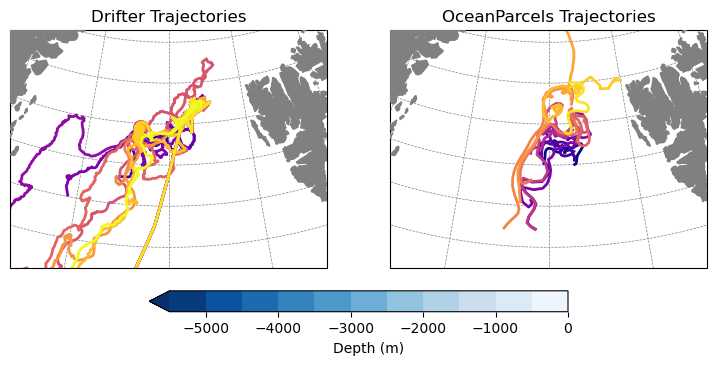

In [ ]:
# Plot the data with cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig, axs = plt.subplots(1, 2, subplot_kw={'projection': ccrs.NorthPolarStereo()}, figsize=(9, 6))
ax1, ax2 = axs
for ax in [ax1, ax2]:
    ax.set_extent([-15, 15, 75, 81], crs=ccrs.PlateCarree())

    if False:
        # Contourf or pcolormesh for bathymetry
        cs = ax.contourf(
            ds_fram_bath['lon'], ds_fram_bath['lat'], ds_fram_bath['z'],
            #levels=np.arange(-6000, 500, 250),
            levels =  np.linspace(-5500, 0, 12) + 0.001,
            cmap="Blues_r",
            extend='min',
            transform=ccrs.PlateCarree()
        )

    
    ax.add_feature(cfeature.LAND, zorder=100, color='gray')
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', linestyle='--')
    gl.top_labels = True   # Turn on labels for the top axis
    gl.bottom_labels = False # Turn off labels for the bottom axis
    gl.left_labels = True   # Keep labels on the left (optional)
    gl.right_labels = False  # Turn off labels on the right (optional)


# Create the colorbar
#cbar = plt.colorbar(cs, ax=axs, orientation='horizontal', label='Depth (m)', shrink=0.6, pad=0.05)
# Invert the colorbar
#cbar.ax.invert_yaxis()

# Plot the drifter data


for i, df in enumerate(DFs[1::2]):
    ax1.plot(df['longitude'], df['latitude'], color=get_colormap_colors(num_colors=len(DFs[1::2]))[i], alpha=1, transform=ccrs.PlateCarree(), linewidth=2)
for i, trajectory in enumerate(ds_parcels.trajectory.values):    
    ax2.plot(ds_parcels.sel(trajectory=trajectory).lon, ds_parcels.sel(trajectory=trajectory).lat, transform=ccrs.PlateCarree(), color=get_colormap_colors(num_colors=len(DFs[1::2]))[i], linewidth=2)

ax1.set_title('Drifter Trajectories')
ax2.set_title('OceanParcels Trajectories')

plt.show()

In [9]:
# Print the first few rows of the txt file

with open(files_drifter[0], "r") as f:
    lines = f.readlines()
    for line in lines[:10]:
        print(line.strip())

Position time (UTC),Reception time (UTC),Latitude (°),Longitude (°),Status
2020-07-07 17:00:00,2020-07-09 18:33:21,0,0,0
2020-07-07 18:00:00,2020-07-09 18:33:21,0,0,0
2020-07-07 19:00:00,2020-07-09 18:33:21,0,0,0
2020-07-09 18:30:00,2020-07-09 18:33:21,0,0,0
2020-07-09 18:40:00,2020-07-09 19:00:45,79.26942,2.87058,1
2020-07-09 18:50:00,2020-07-09 19:00:45,79.29554,3.00272,1
2020-07-09 19:00:00,2020-07-09 19:00:45,79.3201,3.12522,1
2020-07-09 19:10:00,2020-07-09 19:30:35,79.3286,3.16864,1
2020-07-09 19:20:00,2020-07-09 19:30:35,79.32857,3.16864,1


In [3]:
import sys
sys.path.append("/albedo/home/quraus001/FESOM-FS-subduction/functions/")
import FESOM_processing as fprc
import FESOM_plotting as fplt
import pyfesom as pf
import cmocean as cmo

/albedo/home/quraus001/pyfesom/pyfesom/climatology.py:21: UserWarning: The seawater library is deprecated! Please use gsw instead.
  import seawater as sw


In [4]:
meshpath = "/albedo/home/quraus001/Arc08_sub/"
datapath = "/albedo/work/projects/oce_rio/cwekerle/result/Arc40/from_1988_erai/"
plotpath = "/albedo/home/quraus001/FESOM-FS-subduction/plots/"

In [5]:
mesh   = pf.load_mesh(meshpath)
ds_oce = fprc.load_FESOM_data_with_grid(meshpath, datapath + "Arc40.2002.oce.mean.sub.nc", vars="oce")

/albedo/home/quraus001/Arc08_sub/pickle_mesh_py3
3
The usepickle == True)
The pickle file for python 3 exists.
The mesh will be loaded from /albedo/home/quraus001/Arc08_sub/pickle_mesh_py3


In [6]:
t = 66
temp = fprc.reshape_3d_nodes(ds_oce, "temp", time_idx=t)

formatted_date = ds_oce.time[t].values.item().strftime("%Y-%m-%d")
title="Potential Temperature at 100m Depth"# + formatted_date


In [11]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from typing import Optional, Sequence, Tuple, Union

def plot_polar_pcolor(
    mesh: object,
    data: np.ndarray,
    *,
    levels: Optional[Union[np.ndarray, Sequence[float]]] = None,
    cmap: str = 'viridis',
    extend: str = 'both',
    flip_cbar: bool = False,
    extent: Sequence[float] = [-15, 15, 75, 81],
    label: str = "Value",
    figsize: Tuple[float, float] = (5.5, 4),
    title: Optional[str] = None,
    show: bool = True,
    save_path: Optional[str] = None,
    fill_num: Optional[float] = -100,
) -> Optional[Tuple[plt.Figure, plt.Axes]]:
    """
    Plot a tricontourf map of unstructured data on a polar projection.

    Parameters
    ----------
    mesh : object
        Mesh object with attributes:
        - `x2`: 1D numpy array of longitudes (or x-coordinates).
        - `y2`: 1D numpy array of latitudes (or y-coordinates).
        - `elem`: 2D array-like of triangle indices for the mesh.
    data : np.ndarray
        1D array of scalar values defined on the mesh.
    dx : float, optional
        Interval between contour levels (used if `levels` is None), by default 100.
    levels : array-like, optional
        Contour levels. If None, levels are automatically generated from data using `dx`.
    cmap : str, optional
        Name of the matplotlib colormap to use, by default 'viridis'.
    projection : cartopy.crs.Projection, optional
        Map projection for the plot, by default `ccrs.NorthPolarStereo()`.
    extent : list of float, optional
        Geographic extent in [lon_min, lon_max, lat_min, lat_max] (degrees), by default [-20, 20, 75, 82].
    label : str, optional
        Label for the colorbar, by default "Value".
    figsize : tuple of float, optional
        Size of the figure in inches (width, height), by default (8, 6).
    title : str, optional
        Title of the plot, by default None.
    show : bool, optional
        Whether to display the plot using `plt.show()`, by default True.
    save_path : str, optional
        If provided, saves the figure to this path (e.g., "output.png"), by default None.

    Returns
    -------
    (matplotlib.figure.Figure, matplotlib.axes.Axes), optional
        If `show` is False, returns the figure and axis for further use. Otherwise, returns None.
    """
    projection = ccrs.NorthPolarStereo()
    pc = ccrs.PlateCarree()
    x_proj, y_proj = projection.transform_points(pc, mesh.x2, mesh.y2)[:, :2].T

    if levels is None:
        vmin = np.nanmin(data)
        vmax = np.nanmax(data)
        levels = np.linspace(vmin, vmax+10, 10)

    # Check if the array contains NaNs
    if np.any(np.isnan(data)):
        print(f"Replace NaNs with {fill_num}")
        data = np.nan_to_num(data, nan=fill_num)

    fig, ax = plt.subplots(figsize=figsize, subplot_kw={'projection': projection}, constrained_layout=True)
    cf = ax.tripcolor(x_proj, y_proj, mesh.elem, data, cmap=cmap, vmin=levels[0], vmax=levels[-1])

    cbar = plt.colorbar(cf, ax=ax, orientation='vertical', shrink=0.7, extend=extend)
    cbar.set_label(label)
    if flip_cbar:
        cbar.ax.invert_yaxis()  # Flips the colorbar so deeper values are at the bottom


    ax.set_extent(extent, crs=pc)
    ax.coastlines(resolution='10m')
    ax.add_feature(cfeature.LAND, zorder=0, edgecolor='black', facecolor='lightgray')
    gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False, 
                  color='gray', alpha=0.5, linestyle='--')
    gl.right_labels = False   # Show right y-axis labels
    gl.top_labels = False   # Show right y-axis labels



    # 4. Try setting the horizontal alignment directly through the formatters (this might not work directly)
    gl.xlabel_style = {'rotation': 0, 'ha': 'center'}
    gl.ylabel_style = {'rotation': 0, 'ha': 'center'}
    

    if title:
        ax.set_title(title, fontweight='bold')

    if save_path:
        plt.savefig(save_path, dpi=300)

    if show:
        plt.show()
        return None
    else:
        return fig, ax

Replace NaNs with nan


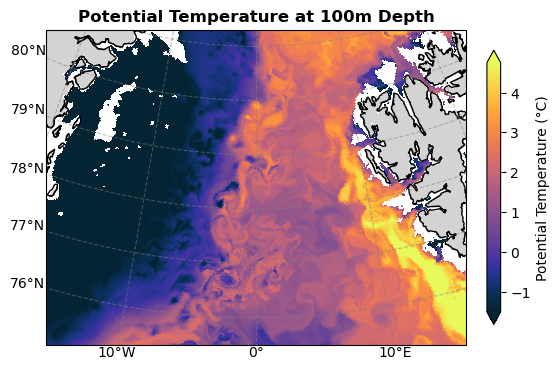

In [12]:
# Use cmocean thermal and set 'bad' color to white
cmap = cmo.cm.thermal.copy()
cmap.set_bad(color='white')

# Plotting
plot_polar_pcolor(mesh, temp[:,10], levels=np.arange(-1.5,5, 0.25), cmap=cmap, extend="both", flip_cbar=False, label="Potential Temperature (°C)", title=title, fill_num=np.nan)


ValueError: z array must not contain non-finite values within the triangulation

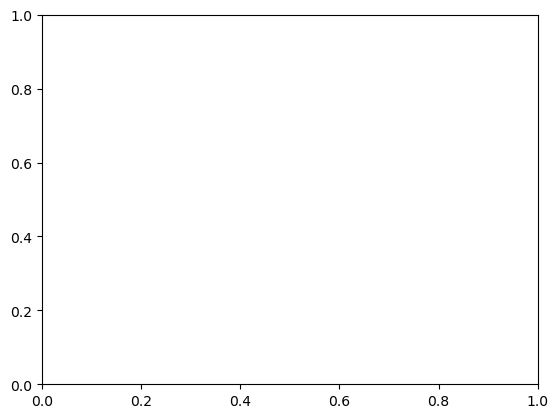

In [44]:
import matplotlib.tri as tri

# Create triangulation with all points
triang = tri.Triangulation(mesh.x2, mesh.y2)

# Mask triangles where any of the three points have z == -100
bad_mask = np.any(temp[:,10][triang.triangles] == -100, axis=1)
triang.set_mask(bad_mask)

# Set colormap and mark bad triangles as white
cmap = cmo.cm.thermal.copy()
cmap.set_bad('white')  # Actually not needed now, but fine to keep

# Plot
plt.tricontourf(triang, temp[:,10], cmap=cmap)